In [1]:
%load_ext autoreload
%autoreload 2
import os
import sys
import io
import torch 
import time
import numpy as np
from collections import OrderedDict

%pylab inline
rcParams["figure.figsize"] = (16,5)
sys.path.append('/home/erogol/projects/')

import librosa
import librosa.display

from torchviz import make_dot, make_dot_from_trace

from TTS.models.tacotron import Tacotron 
from TTS.layers import *
from TTS.utils.data import *
from TTS.utils.audio import AudioProcessor
from TTS.utils.generic_utils import load_config
from TTS.utils.text import text_to_sequence

import IPython
from IPython.display import Audio
from utils import *

Populating the interactive namespace from numpy and matplotlib


In [2]:
def tts(model, text, CONFIG, use_cuda, ap, figures=True):
    t_1 = time.time()
    waveform, alignment, spectrogram = create_speech(model, text, CONFIG, use_cuda, ap) 
    print(" >  Run-time: {}".format(time.time() - t_1))
    if figures:                                                                                                         
        visualize(alignment, spectrogram, CONFIG)                                                                       
    IPython.display.display(Audio(waveform, rate=CONFIG.sample_rate))  
    return alignment, spectrogram

In [3]:
# Set constants
ROOT_PATH = '../result/February-13-2018_01:04AM/'
MODEL_PATH = ROOT_PATH + '/best_model.pth.tar'
CONFIG_PATH = ROOT_PATH + '/config.json'
OUT_FOLDER = ROOT_PATH + '/test/'
CONFIG = load_config(CONFIG_PATH)
use_cuda = False

In [4]:
# load the model
model = Tacotron(CONFIG.embedding_size, CONFIG.hidden_size,
                 CONFIG.num_mels, CONFIG.num_freq, CONFIG.r)

# load the audio processor
ap = AudioProcessor(CONFIG.sample_rate, CONFIG.num_mels, CONFIG.min_level_db,
                    CONFIG.frame_shift_ms, CONFIG.frame_length_ms, CONFIG.preemphasis,
                    CONFIG.ref_level_db, CONFIG.num_freq, CONFIG.power, griffin_lim_iters=80)         


# load model state
if use_cuda:
    cp = torch.load(MODEL_PATH)
else:
    cp = torch.load(MODEL_PATH, map_location=lambda storage, loc: storage)

# # small trick to remove DataParallel wrapper
new_state_dict = OrderedDict()
for k, v in cp['model'].items():
    name = k[7:] # remove `module.`
    new_state_dict[name] = v
cp['model'] = new_state_dict

# load the model
model.load_state_dict(cp['model'])
if use_cuda:
    model.cuda()
model.eval()

 | > Embedding dim : 149


Tacotron(
  (embedding): Embedding(149, 256)
  (encoder): Encoder(
    (prenet): Prenet(
      (layers): ModuleList(
        (0): Linear(in_features=256, out_features=256)
        (1): Linear(in_features=256, out_features=128)
      )
      (relu): ReLU()
      (dropout): Dropout(p=0.5)
    )
    (cbhg): CBHG(
      (relu): ReLU()
      (conv1d_banks): ModuleList(
        (0): BatchNormConv1d(
          (conv1d): Conv1d (128, 128, kernel_size=(1,), stride=(1,), bias=False)
          (bn): BatchNorm1d(128, eps=0.001, momentum=0.99, affine=True)
          (activation): ReLU()
        )
        (1): BatchNormConv1d(
          (conv1d): Conv1d (128, 128, kernel_size=(2,), stride=(1,), padding=(1,), bias=False)
          (bn): BatchNorm1d(128, eps=0.001, momentum=0.99, affine=True)
          (activation): ReLU()
        )
        (2): BatchNormConv1d(
          (conv1d): Conv1d (128, 128, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
          (bn): BatchNorm1d(128, eps=0.001, mo

### EXAMPLES FROM TRAINING SET

In [6]:
import pandas as pd
df = pd.read_csv('/data/shared/KeithIto/LJSpeech-1.0/metadata.csv', delimiter='|')

that he has a 5 an 8 or a 3 before him unless the press work is of the best:


/home/erogol/miniconda3/envs/pytorch/lib/python3.6/site-packages/librosa/util/utils.py:1725: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(x.dtype, float) or np.issubdtype(x.dtype, complex):


 >  Run-time: 8.921625852584839


/home/erogol/miniconda3/envs/pytorch/lib/python3.6/site-packages/librosa/display.py:656: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  if np.issubdtype(data.dtype, np.complex):


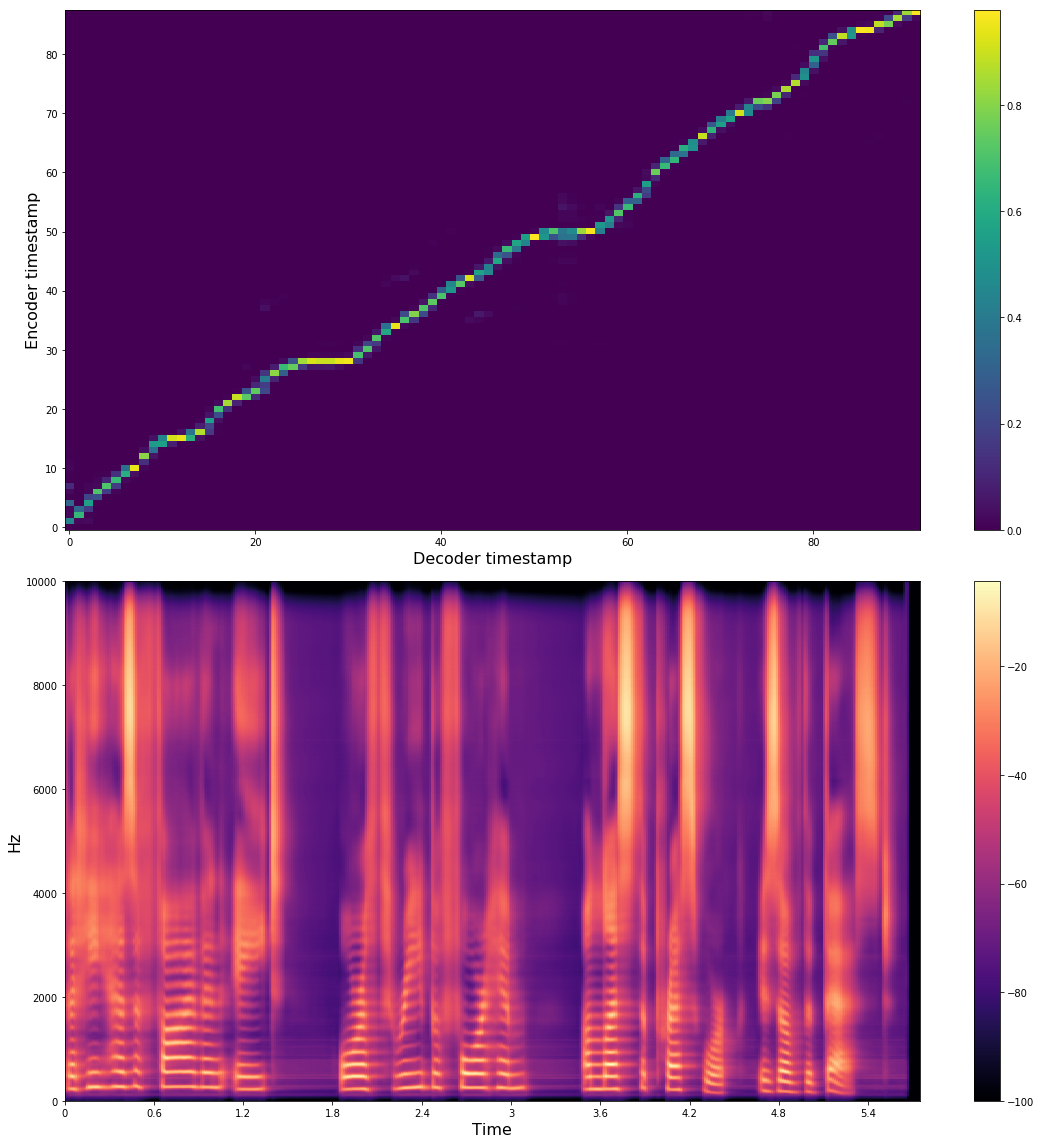

In [7]:
sentence = df.iloc[120, 1].lower().replace(',','')
print(sentence)
align = tts(model, sentence, CONFIG, use_cuda, ap)

### NEW EXAMPLES

/home/erogol/miniconda3/envs/pytorch/lib/python3.6/site-packages/librosa/util/utils.py:1725: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(x.dtype, float) or np.issubdtype(x.dtype, complex):


 >  Run-time: 12.710890054702759


/home/erogol/miniconda3/envs/pytorch/lib/python3.6/site-packages/librosa/display.py:656: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  if np.issubdtype(data.dtype, np.complex):


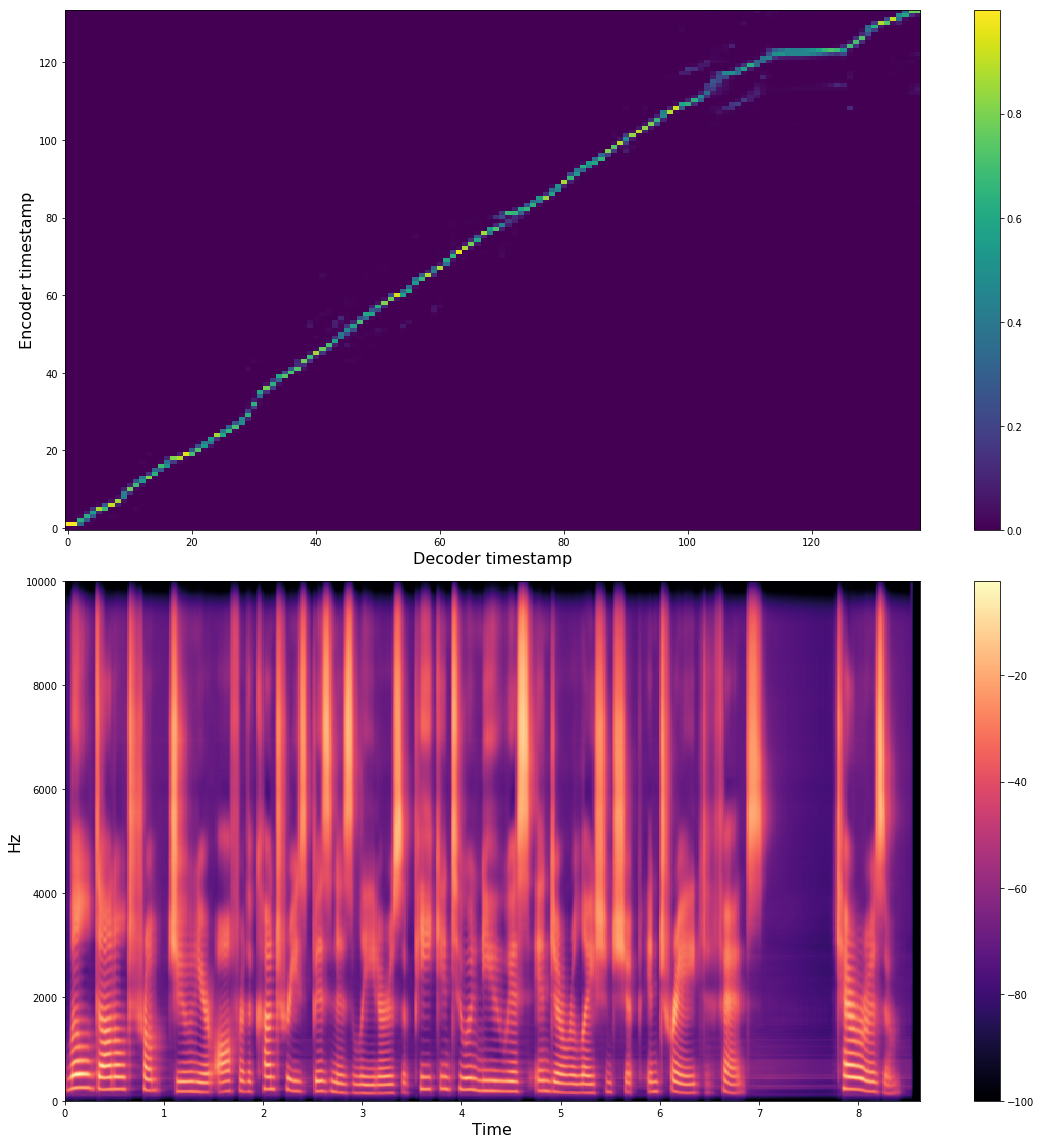

In [5]:
sentence =  "Will Donald Trump Jr. offer the country’s business leaders a peek into a new U.S.-India relationship in trade? Defense? Terrorism?"
model.decoder.max_decoder_steps = 300
alignment = tts(model, sentence, CONFIG, use_cuda, ap)